# Goal: Find drivers of upsets in chess games and create a model to predict upsets 

* Upset is defined as a player with a lower rating winning a game agenst a player with a higher rating
* Model should make a predictions after having 'interviewed' each player as to thier intended opening as white and what defence they intend to use against a given opening as black

### Initial Thoughts

<br>

* Going into this project I am of two minds.

<br>

**First**
* Chess is a skill based game with no random elements (except assigning first move). 
* Because of this the player with the highest level of skill will win any game not determined by variation in player performance. 
* Because of this a given game will be won by the player with the highest level of skill a large majority of the time.
* If this is true conditions underwhich variation in performance is the highest should result in the highest likelyhood of an upset.

<br>

**Second**
* It may also be the case that more skilled players are able to maintain consistancy better than less skilled players under conditions that would increased variation in thier performance.
* If this is true, those conditions may make upsets less likely as the variance would have a grater effect on the the less skilled player than on the more skilled player.

<br>

**Moving Forward**
* Though these two schools of thought may point at differing conclutions, both seem grounded in reason and I am eager to see what the data can tell us

### Initial Hypothisese About Drivers

* There will be few instances of upsets, possibly leading to an imbalanced data set
* As ratings for both players increase, the likelyhood of an upset will decrease 
* As the margin between player ratings increase the likelyhood of an upsets will decrease
* Shorter time incraments will increase the likelyhood of an upset
* Unranked games will have a higher likelyhood of an upset than ranked games
* Games where the higher rated player is moving the white pieces (gaining first move advantage) will have a decreased likelyhood of of an upset
* Some opening/defense stratagies may be more or less prone to upsets
* openings/defences that are more popular or perfered by higher rated players may be more/less prone to upset

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
import re

import wrangle as w

# Acquire

* Data acquired from Kaggle at https://www.kaggle.com/datasnaek/chess
* It contained 20,058 rows and 9 columns before cleaning
* Each row represents a chess game played on Lichess.org
* Each column represents a feature of those games

# Prepare

**Data was very clean initially, I performed the following steps to insure that is was ready for exploration:**
* Removed columns that did not contain useful information\* 
* Renamed columns to premote readability\*
* Checked for nulls in the data (there were none)
* Checked that column data types were apropriate
* Removed white space from values in object columns
* There were no rows lost during preperation
* Added Target column 'upset' indicating weather the lower rated player won the game
* Added additional features to investigate (columns that could be calculated one row at a time)\*
* Split data into train, validate and test (approx. 60/20/20), stratifying on 'upset'
* Added additional features to investigate (columns that requiered an aggregate calculation by column)\*
* aggregat calculations were performed on train data
* resulting calculations were then applied to create columns in train, validate, and test data.

\* See data dictionary for full list of column names

In [2]:
# acquiring, cleaning, and adding pre-split features to data
df = w.wrangle_chess_data(reprep = True)

# Splitting data into train, validate, and test
train, validate, test = w.split_my_data(df)

In [3]:
train.columns

Index(['rated', 'victory_status', 'winning_pieces', 'time_increment',
       'white_rating', 'black_rating', 'opening_name', 'upset', 'rating_dif',
       'game_rating', 'lower_rated_white', 'time_control_group'],
      dtype='object')

# Explore

## How often do upsets occur?

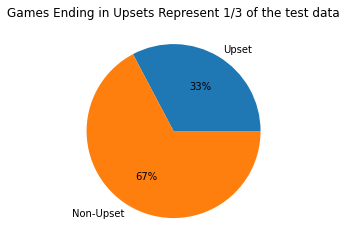

In [4]:
values = [len(train.upset[train.upset == True]), len(train.upset[train.upset == False])] 
labels = ['Upset','Non-Upset', ] 
plt.pie(values, labels=labels, autopct='%.0f%%')
plt.title('Games Ending in Upsets Represent 1/3 of the test data')
plt.show()

**About 1/3 of games will end in an upset** <br>
This is much higher than I expected and may be do to the Lichess.org matching system pairing similarly rated players for matches.

## Dose first turn advantage effect upsets?

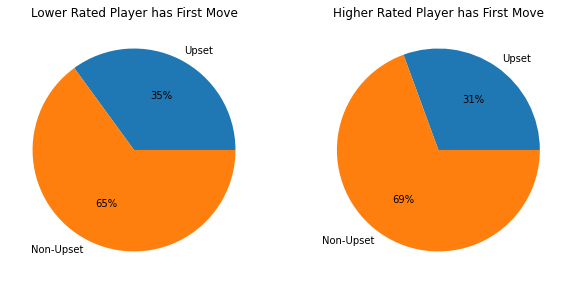

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
#fig.suptitle('Upset Percentage is 4% Higher in Games Where the Lower Rated Player has the First Move')

values = [len(train.upset[(train.lower_rated_white == True) & (train.upset == True)]),
          len(train.upset[(train.lower_rated_white == True) & (train.upset == False)])]
labels = ['Upset', 'Non-Upset']

ax1.pie(values, labels=labels, autopct='%.0f%%')
ax1.title.set_text('Lower Rated Player has First Move')

values = [len(train.upset[(train.lower_rated_white == False) & (train.upset == True)]),
          len(train.upset[(train.lower_rated_white == False) & (train.upset == False)])]
labels = ['Upset', 'Non-Upset'] 

ax2.pie(values, labels=labels, autopct='%.0f%%')
ax2.title.set_text('Higher Rated Player has First Move')

plt.show()

**Upset Percentage is 4% Higher in Games Where the Lower Rated Player has the First Move.** <br>
This is lower than I expected. I will now use a chi-square test to investigate whether this pattern will hold for the total population of chess games.



**Ho: "Games ending in Upset" and "The lower ranked player having the first move" are independant of one another.** 

**Ha: "Games ending in Upset" and "The lower ranked player having the first move" are dependant on one another.**

**I will be using a confidance interval of 95% resulting an an alpha of .05.**

In [12]:
observed = pd.crosstab(train.lower_rated_white, train.upset)

chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

chi^2 = 24.9953
p     = 0.0000


**Because our P value is less than our alpha we can conclude that there is a high likelyhood that "Games ending in Upset" and "The lower ranked player having the first move" are dependant on one another. For this reason I expect to see the same 4% difference observed in our sampe to be reflected in the total population of chess games. For that reason, I believe that "lower rated player has fist move" is a benificial feature to model on**

## Does a game being rated effect upsets?

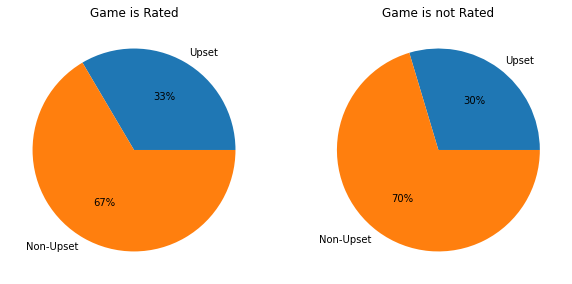

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
#fig.suptitle('Upset Percentage is 4% Higher in Games Where the Lower Rated Player has the First Move')

values = [len(train.upset[(train.rated == True) & (train.upset == True)]),
          len(train.upset[(train.rated == True) & (train.upset == False)])]
labels = ['Upset', 'Non-Upset']

ax1.pie(values, labels=labels, autopct='%.0f%%')
ax1.title.set_text('Game is Rated')

values = [len(train.upset[(train.rated == False) & (train.upset == True)]),
          len(train.upset[(train.rated == False) & (train.upset == False)])]
labels = ['Upset', 'Non-Upset'] 

ax2.pie(values, labels=labels, autopct='%.0f%%')
ax2.title.set_text('Game is not Rated')

plt.show()

**Rated games show no difference in the percentage of upsets compared to the full sample population. <br>
Unrated games show a 3% fewer upsets compared to the sample population.** <br>
I would have guessed that rated games had fewer upsets, but that seems not to be the case. <br>
I wil now use a chi-square test to see if this patern is likely to hold for the entire population of chess games

**Ho: "Game is rated" and "Game ended in Upset" are independant of one another.** 

**Ha: "Game is rated" and "Game ended in Upset" are dependant of one another.**

**I will be using a confidance interval of 95% resulting an an alpha of .05.**

In [14]:
observed = pd.crosstab(train.rated, train.upset)

chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

chi^2 = 11.7329
p     = 0.0006


**Because our P value is less than our alpha we can conclude that there is a high likelyhood that "Games ending in Upset" and "Game is rated" are dependant on one another. For this reason I expect to see the same 3% difference observed in our sampe to be reflected in the total population of chess games. For that reason, I believe that "Game is rated" is a benificial feature to model on.**

## Does player rating have an effect on upsets?

In [22]:
game_ratng_upsets = train.game_rating[(train.upset == True)].mean()
game_ratng_upsets

1586.695403861844

In [23]:
game_rating_nonupsets = train.game_rating[(train.upset == False)].mean()
game_rating_nonupsets

1592.3438782263402

In [25]:
print(train.game_rating[(train.upset == False)].var())
print(train.game_rating[(train.upset == True)].var())

70933.43905273586
64131.140057759905


In [27]:
stats.ttest_ind(train.game_rating[(train.upset == True)], train.game_rating[(train.upset == False)], equal_var=True)

Ttest_indResult(statistic=-1.071684204242657, pvalue=0.28388492819717703)

## Does time block effect upsets?

In [15]:
train.time_control_group.value_counts()

10     5319
15     1894
5       980
8       534
20      529
30      400
7       363
25      179
9       141
12      129
6       102
45       89
180      82
60       55
11       51
13       44
14       38
3        35
2        35
16       32
4        30
0        27
17       25
40       25
1        18
19       17
18       16
35       12
90       11
120      10
150       8
21        1
29        1
Name: time_control_group, dtype: int64